In [1]:
import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()
print("Initalize")

Initalize


In [2]:
df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [3]:
df.createOrReplaceTempView("df")

How many different cases are there, by department?

Text(0.5, 0, 'Number of Cases')

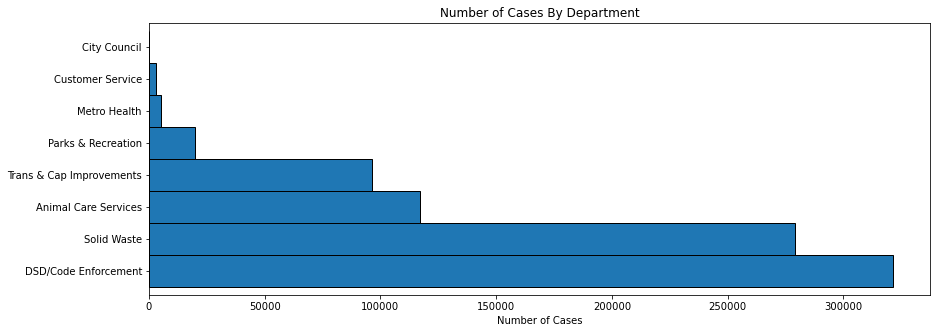

In [4]:
# Using spark syntax
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

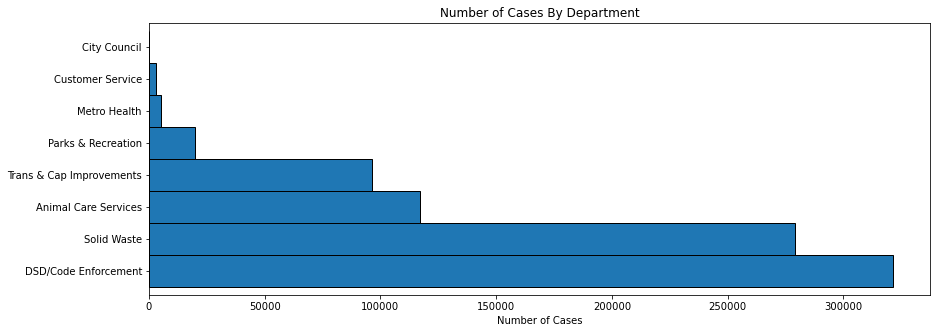

In [5]:
# using SQL

spark.sql(
"""
Select department, count(*) as count
from df
group by department
"""
).toPandas().set_index("department")["count"].sort_values(ascending=False).plot.barh(width=1, edgecolor="black", figsize=(14, 5))

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.show()

Does the percentage of cases that are late vary by department?

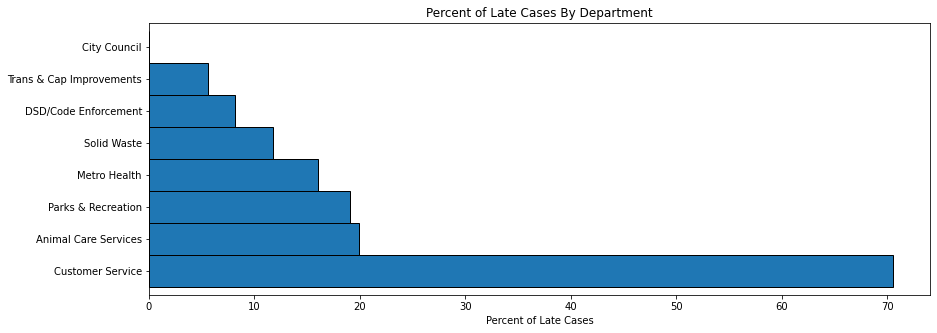

In [6]:
# using SQL

spark.sql(
"""
Select department, round(sum(case when case_late = 'true' then 1 else 0 end)/count(*) * 100, 2) as percent_late
from df
group by department
"""
).toPandas().set_index("department")["percent_late"].sort_values(ascending=False).plot.barh(width=1, edgecolor="black", figsize=(14, 5))

plt.title("Percent of Late Cases By Department")
plt.ylabel("")
plt.xlabel("Percent of Late Cases")
plt.show()

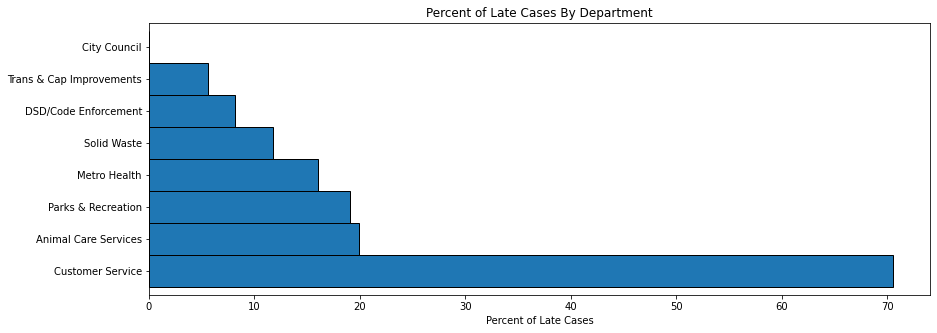

In [7]:
# Using spark syntax

(
df.withColumn("case_late", (df.case_late == 'true').cast("int"))
    .groupby("department")
    .agg(round(sum("case_late")/count(df.case_id)*100, 2).alias("percent_late"))
    .toPandas()
    .set_index("department")["percent_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Percent of Late Cases By Department")
plt.ylabel("")
plt.xlabel("Percent of Late Cases")
plt.show()

On average, how late are the late cases by department?

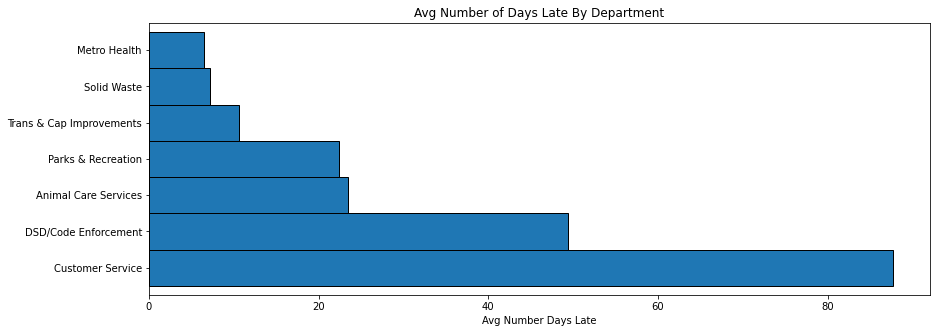

In [8]:
(df.filter(df.case_late == 'true')
 .groupby(df.department)
 .agg(avg('num_days_late').alias('avg_days_late'))
 .toPandas()
 .set_index("department")["avg_days_late"]
 .sort_values(ascending=False)
 .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Avg Number of Days Late By Department")
plt.ylabel("")
plt.xlabel("Avg Number Days Late")
plt.show()

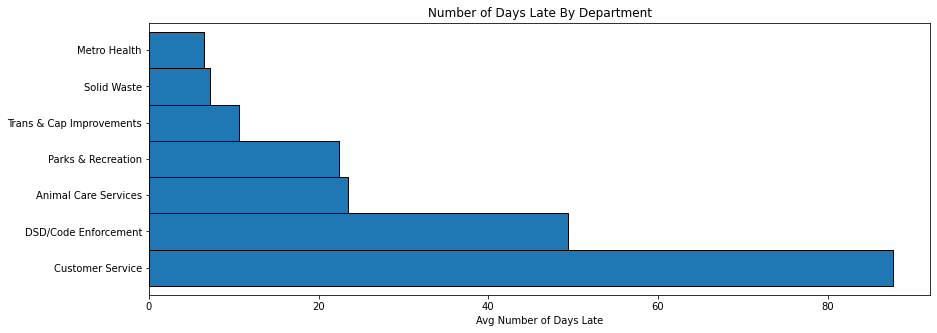

In [9]:
# using SQL

spark.sql(
"""
Select department, avg(num_days_late) as avg_num_days_late
from df
where case_late = 'true'
group by department
"""
).toPandas().set_index("department")["avg_num_days_late"].sort_values(ascending=False).plot.barh(width=1, edgecolor="black", figsize=(14, 5))

plt.title("Number of Days Late By Department")
plt.ylabel("")
plt.xlabel("Avg Number of Days Late")
plt.show()

What is the service type that is the most late? Just for Parks & Rec?

In [10]:
df.groupby(df.service_request_type).agg(avg(df.num_days_late).alias('num_days_late')).toPandas().set_index("service_request_type")["num_days_late"].sort_values(ascending=False)

service_request_type
Zoning: Junk Yards                         175.956362
Labeling for Used Mattress                 162.430329
Record Keeping of Used Mattresses          153.997240
Signage Requied for Sale of Used Mattr     151.638681
Storage of Used Mattress                   142.112556
                                             ...     
Stray Animal                              -998.804573
Signal Timing Modification By Engineer   -1247.079780
Engineering Design                       -1399.127234
CCO_Request for Research/Information_1            NaN
Request for Research/Information                  NaN
Name: num_days_late, Length: 335, dtype: float64

In [11]:
(df.filter(df.department == "Parks & Recreation")
 .groupby(df.service_request_type)
 .agg(avg(df.num_days_late).alias('num_days_late'))
 .toPandas()
 .set_index("service_request_type")["num_days_late"]
 .sort_values(ascending=False)
)

service_request_type
Reservation Assistance                    66.031163
Park Building Maint Invest                24.322321
Sportfield Lighting                       19.377091
Electrical                                11.750505
Amenity Park Improvement                  10.114974
Tree Removal                               5.658236
Painting                                   4.354412
Tree Trimming/Maintenance                  4.241499
General Building Maintenance               4.191946
Masonry                                    4.175698
Sign Maintenance                           4.141524
Fence/Gate Repair                          3.864462
Miscellaneous Park Equipment               2.460052
Trail/Greenway Maintenance                 1.691469
Carpentry                                  0.507442
Fencing                                   -0.170123
Graffiti                                  -0.238376
Welding                                   -0.319888
Brush/Debris Collection                   -

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [12]:
(df.filter(df.department == "DSD/Code Enforcement")
 .groupby(df.service_request_type)
 .count()
 .toPandas()
 .set_index("service_request_type")["count"]
 .sort_values(ascending=False)
 .head()
)

service_request_type
Overgrown Yard/Trash                65895
Bandit Signs                        32910
Front Or Side Yard Parking          28794
Junk Vehicle On Private Property    21473
Alley-Way Maintenance               20214
Name: count, dtype: int64

In [14]:
(df.filter(df.department == "Solid Waste")
 .groupby(df.service_request_type)
 .count()
 .toPandas()
 .set_index("service_request_type")["count"]
 .sort_values(ascending=False)
 .head()
)

service_request_type
No Pickup                86855
Damaged Cart             30338
Cart Exchange Request    22024
Lost/Stolen Cart         18731
Dead Animal - Dog        16714
Name: count, dtype: int64

Does whether or not its a weekend matter for when a case is opened/closed?

In [45]:
df = (
    df.withColumn("case_opened_day", date_format(col("case_opened_date"), "E"))
    .withColumn("case_closed_day", date_format(col("case_closed_date"), "E"))
)

In [51]:
df.createOrReplaceTempView("df")

weekend = spark.sql(
"""
Select case_id, 
       Case 
           when case_opened_day = 'Sun' or case_opened_day = 'Sat' then 1 else 0 end as opened_weekend,
       Case 
           when case_closed_day = 'Sun' or case_closed_day = 'Sat' then 1 else 0 end as closed_weekend
from df
"""
).toPandas()

weekend

,case_id,opened_weekend,closed_weekend
0,1014127332,0,0
1,1014127333,0,0
2,1014127334,0,0
3,1014127335,0,0
4,1014127336,0,0
...,...,...,...
841699,1014127325,1,1
841700,1014127326,1,0
841701,1014127327,1,0
841702,1014127329,1,0


In [55]:
from scipy import stats
observed = pd.crosstab(weekend.case_id, weekend.opened_weekend)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 841704.0000
p     = 0.4651


On average, how many cases are opened a day for the Customer Service department?

In [64]:
spark.sql(
"""
Select avg(count) from (Select date(case_opened_date) as day, count(case_id) as count
from df
where department = 'Customer Service'
group by date(case_opened_date))
"""
).show()

+-----------+
| avg(count)|
+-----------+
|5.564453125|
+-----------+



Does the number of service requests for the solid waste department vary by day of the week?

In [74]:
spark.sql(
"""
select case_opened_day, avg(count) as avg_cases
from (select date(case_opened_date), case_opened_day, count(case_id) as count
from df
where department = 'Solid Waste'
group by case_opened_day, date(case_opened_date)
)
group by case_opened_day
"""
).show()

+---------------+------------------+
|case_opened_day|         avg_cases|
+---------------+------------------+
|            Sun| 81.96428571428571|
|            Mon| 691.4880952380952|
|            Thu| 574.9156626506024|
|            Sat|184.48192771084337|
|            Wed| 499.3690476190476|
|            Fri| 616.9036144578313|
|            Tue| 691.9047619047619|
+---------------+------------------+

